<img src="img/mvp_art.png" width=200 height=200 />

# Predicting the NBA's Most Valuable Player
### CMSC 320 Final Project
#### John Newhagen, Rahul Reddy, & Austin Smith
---

### Project Description:
In this project, we aim to...

Sources: https://www.basketball-reference.com/, https://basketball.realgm.com/
___

### Importing Packages and Modifying Settings
Before we can begin collecting our data, we must import the packages that will be used throughout the project.\
First, two packages (os and subprocess) that will allow us to modify the file structure of our project folder to add and update files.\
Secondly, several packages that will allow us to do web-scraping on basketball-reference due to an issue with pandas. selenium is an automated browser engine which will allow us to run firefox remotely through a webdriver. Along with this, the selenium options will allow us to set firefox to run in the background. Finally, Contextlib2 is required for our web-scraping code and Unidecode will allow us to clean links of any unwanted characters.
Next, pandas and numpy which will allow us to properly clean and display our data.\
Then, matplotlib and seaborn will be used for plotting our data.\
Finally, SciKit Learn and SciPy will be used to create a model for MVP Voting Share.\

In [1]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
# File-managing packages
import os
import subprocess
# Web-scraping packages
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
options = Options()
options.headless = True
import contextlib2
import unidecode as uni
# Data-handling packages
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
# Plotting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
register_matplotlib_converters()
import seaborn as sns
sns.set(style="darkgrid")
# Regression Modeling packages
from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as rcr
from sklearn.metrics import classification_report
from scipy import stats

## Finding MVP Candidates
---

The first step in our process is determining who has won the NBA's Most Valuable player award and who the candidates for MVP have been since the 2000-01 NBA season. This cutoff was used as the NBA and basketball have changed over the years so constraining our data to the most recent 18 seasons should allow us to account for some of the changes while still collecting enough data to create a realistic model of MVP Voting Share.\
First we create a couple functions that will allow us to modify the table we will be scraping from basketball-reference.

In [2]:
# This function takes a pandas dataframe and renames all unnamed levels to remove them from the table
# Returns the rennamed dataframe
def rename_unnamed(df):
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if 'Unnamed: ' in row:
                columns_new[j] = ''
        df = df.rename(columns=dict(zip(columns.tolist(), columns_new)), level=i)
    return df
# This fuction takes a pandas dataframe and collapses the columns of a MultiIndexed pandas dataframe
# Returns the collapsed dataframe
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: "".join(x))
    return df

Now that we have those, we can proceed by creating a dictionary of tables containing the top 5 MVP candidates from 2001 to 2019 and their Rank and VotingShare.\
First, we use pandas to obtain the table containing our data, then we modify the table using the functions declared above, and finally we select the columns we want and add them to the votes dictionary with the key value of the season.

In [33]:
votes = {}
for i in range(2001,2020):
    data = pd.read_html('https://www.basketball-reference.com/awards/awards_' + str(i) + '.html')[0]
    data = collapse_columns(rename_unnamed(data))
    votes[i] = data.loc[:4, ['Rank', 'Player', 'Tm', 'VotingShare']]

## MVP Candidate Database Builder
---

Now that we have a list of MVP candidates and their voting shares, we want to collect some statistics for all of our MVP candidates.\
We will be collecting data in terms of four separate metrics: 
* Per-Game statistics
* Advanced statistics
* Team statistics
* Contribution statistics (Per-Game/Team)

First, we declare a function that will allow us to access more than just the first table from basketball-reference unlike what we did above.\
Unfortunately, due to the construction of the html code for basketball-reference, only the per-game statistics table is accessible using the standard pandas read_html() function. So, we have used a combination of pandas and selenium to 

In [4]:
# This function takes a snippet of a link to a player's profile page and scrapes basketball reference using 
# firefox through a selenium webdriver.
# The function returns a list containing two tables, the player's per-game stats and advanced stats for their whole
# career
# Code adapted from: https://stackoverflow.com/questions/27113978/pandas-read-html-returns-only-one-table
def browse(link):
    @contextlib2.contextmanager
    def quitting(thing):
        yield thing
        thing.quit()
    with quitting(webdriver.Firefox(options=options)) as driver:
        link = 'https://www.basketball-reference.com/players/' + link + '.html' 
        driver.get(link)
        content = driver.page_source
        with open('/tmp/out.html', 'wb') as f:
            f.write(content.encode('utf-8'))
            tables = pd.read_html(content)
        for i, table in enumerate(tables):
            if all(x == y for x, y in 
                   zip(table.columns, ['Season', 'Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', 
                                       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 
                                       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'])):
                t1 = table
                t2 = tables[i+4]
                break
        return [t1, t2]

In [5]:
if not(os.path.isdir('MVP_Data')):
    subprocess.call(['mkdir','MVP_Data'])
for year in votes:
    for name in votes[year]['Player']:
        if not(os.path.isdir('MVP_Data/' + str(year) + '/' + name)):
            if not name in (['Isaiah Thomas', 'Anthony Davis']):
                link = str.lower(name.split()[1])[:1] + '/' + \
                        uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                            str.lower(name.split()[0]).replace("'", "")[:2] + '01'
            else:
                link = str.lower(name.split()[1])[:1] + '/' + \
                        uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                            str.lower(name.split()[0]).replace("'", "")[:2] + '02'

            data = browse(link)

            path = 'MVP_Data/' + str(year)
            subprocess.call(['mkdir', path])
            path += '/' + name
            subprocess.call(['mkdir', path])

            pergame = data[0]
            pergame.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
            if pergame['3P%'].isnull().any():
                pergame.drop(columns='3P%',inplace=True)
            pergame.dropna(inplace=True)
            pergame['Season'] = [int(str(x).split('-')[0])+1 for x in pergame['Season']]
            pergame['Age'] = pergame['Age'].astype(int)
            pergame['G'] = pergame['G'].astype(int)
            pergame['GS'] =pergame['GS'].astype(int)
            pergame = pergame[pergame['Season'] == year]
            pergame.reset_index(inplace=True,drop=True)
            pergame = pergame.reindex(columns=['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST',
                                               'STL', 'BLK', 'TOV', 'FG%', '3P%', 'eFG%', 'FT%'])
            pergame.to_csv(path + '/PerGame.csv')

            advanced = data[1]
            if 'Unnamed: 19' in advanced.columns:
                advanced.drop(columns=['Unnamed: 19', 'Unnamed: 24'],inplace=True)
            advanced.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
            advanced.dropna(inplace=True)
            advanced['Season'] = [int(str(x).split('-')[0])+1 for x in advanced['Season']]
            advanced['Age'] = advanced['Age'].astype(int)
            advanced['G'] = advanced['G'].astype(int)
            advanced = advanced[advanced['Season'] == year]
            advanced.reset_index(inplace=True,drop=True)
            advanced = advanced.reindex(columns=['Season', 'Tm', 'Pos', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 
                                                 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 
                                                 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'])
            advanced.to_csv(path + '/Advanced.csv')

            tm = votes[year][votes[year]['Player'] == name].reset_index()['Tm'][0]
            if tm == 'NOP':
                tm = 'NOH'
            team = pd.read_html('https://www.basketball-reference.com/teams/' + tm + \
                                '/stats_per_game_totals.html')[0]
            team.replace('Season', '0000-00', inplace=True)
            team['Season'] = [int(str(x).split('-')[0])+1 for x in team['Season']]
            team = team[team['Season'] == year]
            team['Win_Pct'] = team['W'].astype(int)/team['G'].astype(int)
            team = team.reindex(columns=['Season', 'Tm', 'W', 'L', 'Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 
                                           'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%'])
            team.to_csv(path + '/Team.csv')

In [30]:
def tabulate(row, i):
    row.drop(columns='Unnamed: 0', inplace=True)
    row['Name'] = name
    row['VotingShare'] = votes[year]['VotingShare'][i]
    row['Ranking'] = votes[year]['Rank'][i]
    row['Candidate'] = row['Name'] + ', ' + row['Season'].astype(str)
    row.replace(np.nan, 0, inplace=True)
    return row
    
pg = pd.DataFrame()
adv = pd.DataFrame()
tm = pd.DataFrame()
for year in votes:
    i = 0
    for name in votes[year]['Player']:
        path = 'MVP_Data/' + str(year) + '/' + name
        pg = pg.append(tabulate(pd.read_csv(path + '/PerGame.csv'), i), ignore_index=True)
        adv = adv.append(tabulate(pd.read_csv(path + '/Advanced.csv'), i), ignore_index=True)
        tm = tm.append(tabulate(pd.read_csv(path + '/Team.csv'), i), ignore_index=True)
        i += 1
        
ctb = pg.copy(deep=True)[['Season', 'Tm', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 
                          'FT%', 'Name', 'Ranking', 'VotingShare', 'Candidate']]
ctb['PTS_CTB'] = ctb['PTS']/tm['PTS']
ctb['ORB_CTB'] = ctb['ORB']/tm['ORB']
ctb['DRB_CTB'] = ctb['DRB']/tm['DRB']
ctb['TRB_CTB'] = ctb['TRB']/tm['TRB']
ctb['AST_CTB'] = ctb['AST']/tm['AST']
ctb['STL_CTB'] = ctb['STL']/tm['STL']
ctb['BLK_CTB'] = ctb['BLK']/tm['BLK']
ctb['TOV_CTB'] = ctb['TOV']/tm['TOV']
ctb.drop(columns=['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%'], inplace=True)

In [31]:
# Per Game Statistics
pg.head(10)

,Season,Tm,Pos,G,MP,PTS,ORB,DRB,TRB,AST,...,BLK,TOV,FG%,3P%,eFG%,FT%,Name,VotingShare,Ranking,Candidate
0,2001,PHI,SG,71,42.0,31.1,0.7,3.1,3.8,4.6,...,0.3,3.3,0.420,0.000,0.447,0.814,Allen Iverson,0.904,1,"Allen Iverson, 2001"
1,2001,SAS,PF,82,38.7,22.2,3.2,9.0,12.2,3.0,...,2.3,3.0,0.499,0.259,0.502,0.618,Tim Duncan,0.569,2,"Tim Duncan, 2001"
2,2001,LAL,C,74,39.5,28.7,3.9,8.8,12.7,3.7,...,2.8,2.9,0.572,0.000,0.572,0.513,Shaquille O'Neal,0.466,3,"Shaquille O'Neal, 2001"
3,2001,SAC,PF,70,40.5,27.1,2.6,8.5,11.1,4.2,...,1.7,2.8,0.481,0.000,0.481,0.703,Chris Webber,0.420,4,"Chris Webber, 2001"
4,2001,MIN,PF,81,39.5,22.0,2.7,8.7,11.4,5.0,...,1.8,2.8,0.477,0.000,0.484,0.764,Kevin Garnett,0.122,5,"Kevin Garnett, 2001"
5,2002,SAS,PF,82,40.6,25.5,3.3,9.4,12.7,3.7,...,2.5,3.2,0.508,0.100,0.508,0.799,Tim Duncan,0.757,1,"Tim Duncan, 2002"
6,2002,NJN,PG,82,37.3,14.7,1.6,5.7,7.3,9.9,...,0.2,3.5,0.391,0.000,0.442,0.814,Jason Kidd,0.712,2,"Jason Kidd, 2002"
7,2002,LAL,C,67,36.1,27.2,3.5,7.2,10.7,3.0,...,2.0,2.6,0.579,0.000,0.579,0.555,Shaquille O'Neal,0.552,3,"Shaquille O'Neal, 2002"
8,2002,ORL,SG,76,38.3,25.6,2.0,5.9,7.9,5.3,...,1.0,2.5,0.451,0.000,0.483,0.748,Tracy McGrady,0.310,4,"Tracy McGrady, 2002"
9,2002,LAL,SG,80,38.3,25.2,1.4,4.1,5.5,5.5,...,0.4,2.8,0.469,0.250,0.479,0.829,Kobe Bryant,0.078,5,"Kobe Bryant, 2002"


In [32]:
# Advanced Statistics
adv.head(10)

,Season,Tm,Pos,G,MP,PER,TS%,3PAr,FTr,ORB%,...,WS,WS/48,OBPM,DBPM,BPM,VORP,Name,VotingShare,Ranking,Candidate
0,2001,PHI,SG,71,2979.0,24.0,0.518,0.169,0.397,1.9,...,11.8,0.190,5.0,-0.1,4.8,5.1,Allen Iverson,0.904,1,"Allen Iverson, 2001"
1,2001,SAS,PF,82,3174.0,23.8,0.536,0.019,0.471,9.7,...,13.2,0.200,1.8,3.6,5.4,5.9,Tim Duncan,0.569,2,"Tim Duncan, 2001"
2,2001,LAL,C,74,2924.0,30.2,0.574,0.001,0.684,11.3,...,14.9,0.245,5.7,1.6,7.3,6.8,Shaquille O'Neal,0.466,3,"Shaquille O'Neal, 2001"
3,2001,SAC,PF,70,2836.0,24.7,0.516,0.017,0.282,7.0,...,11.0,0.186,2.6,2.4,4.9,4.9,Chris Webber,0.420,4,"Chris Webber, 2001"
4,2001,MIN,PF,81,3202.0,23.9,0.531,0.045,0.317,7.7,...,11.8,0.176,3.0,2.7,5.7,6.2,Kevin Garnett,0.122,5,"Kevin Garnett, 2001"
5,2002,SAS,PF,82,3329.0,27.0,0.576,0.007,0.466,9.6,...,17.8,0.257,3.9,3.8,7.6,8.1,Tim Duncan,0.757,1,"Tim Duncan, 2002"
6,2002,NJN,PG,82,3056.0,19.1,0.484,0.320,0.217,4.7,...,8.9,0.140,2.8,2.2,5.1,5.4,Jason Kidd,0.712,2,"Jason Kidd, 2002"
7,2002,LAL,C,67,2422.0,29.7,0.590,0.001,0.583,10.8,...,13.2,0.262,5.5,1.5,7.0,5.5,Shaquille O'Neal,0.552,3,"Shaquille O'Neal, 2002"
8,2002,ORL,SG,76,2912.0,25.1,0.532,0.178,0.350,5.7,...,11.5,0.189,5.2,0.8,6.0,5.9,Tracy McGrady,0.310,4,"Tracy McGrady, 2002"
9,2002,LAL,SG,80,3063.0,23.2,0.544,0.083,0.369,4.1,...,12.7,0.199,4.4,0.1,4.4,5.0,Kobe Bryant,0.078,5,"Kobe Bryant, 2002"


In [9]:
# Team Statistics
tm.head(10)

,Season,Tm,W,L,Win_Pct,PTS,ORB,DRB,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare,Ranking,Candidate
0,2001,PHI,56,26,0.682927,94.7,13.1,31.7,44.8,20.6,8.4,5.0,15.8,0.447,0.326,0.745,Allen Iverson,0.904,1,"Allen Iverson, 2001"
1,2001,SAS,58,24,0.707317,96.2,11.0,33.1,44.1,21.7,6.9,7.0,14.0,0.461,0.407,0.715,Tim Duncan,0.569,2,"Tim Duncan, 2001"
2,2001,LAL,56,26,0.682927,100.6,13.2,31.5,44.7,23.0,6.9,6.0,14.4,0.465,0.344,0.683,Shaquille O'Neal,0.466,3,"Shaquille O'Neal, 2001"
3,2001,SAC,55,27,0.670732,101.7,12.0,33.0,45.0,22.6,9.7,5.3,14.9,0.449,0.354,0.771,Chris Webber,0.420,4,"Chris Webber, 2001"
4,2001,MIN,47,35,0.573171,97.3,12.2,30.1,42.3,25.4,8.3,5.6,13.9,0.458,0.357,0.785,Kevin Garnett,0.122,5,"Kevin Garnett, 2001"
5,2002,SAS,58,24,0.707317,96.7,11.1,31.3,42.4,20.0,7.6,6.5,14.4,0.458,0.362,0.742,Tim Duncan,0.757,1,"Tim Duncan, 2002"
6,2002,NJN,52,30,0.634146,96.2,12.7,30.7,43.3,24.3,8.7,6.0,14.5,0.446,0.338,0.735,Jason Kidd,0.712,2,"Jason Kidd, 2002"
7,2002,LAL,58,24,0.707317,101.3,12.5,31.8,44.3,23.0,7.6,5.8,12.7,0.461,0.354,0.699,Shaquille O'Neal,0.552,3,"Shaquille O'Neal, 2002"
8,2002,ORL,44,38,0.536585,100.5,11.5,29.8,41.2,22.0,8.1,4.7,13.6,0.448,0.373,0.754,Tracy McGrady,0.310,4,"Tracy McGrady, 2002"
9,2002,LAL,58,24,0.707317,101.3,12.5,31.8,44.3,23.0,7.6,5.8,12.7,0.461,0.354,0.699,Kobe Bryant,0.078,5,"Kobe Bryant, 2002"


In [10]:
# Contribution Statistics
ctb.head(10)

,Season,Tm,Name,Ranking,VotingShare,Candidate,PTS_CTB,ORB_CTB,DRB_CTB,TRB_CTB,AST_CTB,STL_CTB,BLK_CTB,TOV_CTB
0,2001,PHI,Allen Iverson,1,0.904,"Allen Iverson, 2001",0.328405,0.053435,0.097792,0.084821,0.223301,0.297619,0.060000,0.208861
1,2001,SAS,Tim Duncan,2,0.569,"Tim Duncan, 2001",0.230769,0.290909,0.271903,0.276644,0.138249,0.130435,0.328571,0.214286
2,2001,LAL,Shaquille O'Neal,3,0.466,"Shaquille O'Neal, 2001",0.285288,0.295455,0.279365,0.284116,0.160870,0.086957,0.466667,0.201389
3,2001,SAC,Chris Webber,4,0.420,"Chris Webber, 2001",0.266470,0.216667,0.257576,0.246667,0.185841,0.134021,0.320755,0.187919
4,2001,MIN,Kevin Garnett,5,0.122,"Kevin Garnett, 2001",0.226105,0.221311,0.289037,0.269504,0.196850,0.168675,0.321429,0.201439
5,2002,SAS,Tim Duncan,1,0.757,"Tim Duncan, 2002",0.263702,0.297297,0.300319,0.299528,0.185000,0.092105,0.384615,0.222222
6,2002,NJN,Jason Kidd,2,0.712,"Jason Kidd, 2002",0.152807,0.125984,0.185668,0.168591,0.407407,0.241379,0.033333,0.241379
7,2002,LAL,Shaquille O'Neal,3,0.552,"Shaquille O'Neal, 2002",0.268509,0.280000,0.226415,0.241535,0.130435,0.078947,0.344828,0.204724
8,2002,ORL,Tracy McGrady,4,0.310,"Tracy McGrady, 2002",0.254726,0.173913,0.197987,0.191748,0.240909,0.197531,0.212766,0.183824
9,2002,LAL,Kobe Bryant,5,0.078,"Kobe Bryant, 2002",0.248766,0.112000,0.128931,0.124153,0.239130,0.197368,0.068966,0.220472


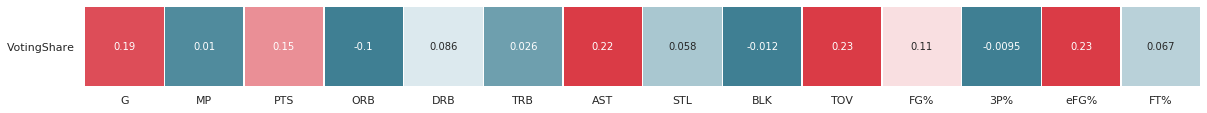

In [11]:
cmap = sns.diverging_palette(220,10, as_cmap=True)
temp = pg.drop(columns=['Season', 'Tm', 'Candidate'])
corr = temp.corr()[['G','MP','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%','eFG%','FT%']]
corr = corr.take([len(temp.corr().columns)-2])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
plt.yticks(rotation=0)
plt.show()

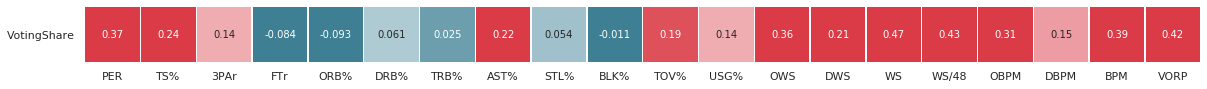

In [12]:
temp = adv.drop(columns=['Season', 'Tm', 'Candidate'])
corr = temp.corr()[['PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS',
                   'WS','WS/48','OBPM','DBPM','BPM','VORP']]
corr = corr.take([len(temp.corr().columns)-2])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
plt.yticks(rotation=0)
plt.show()

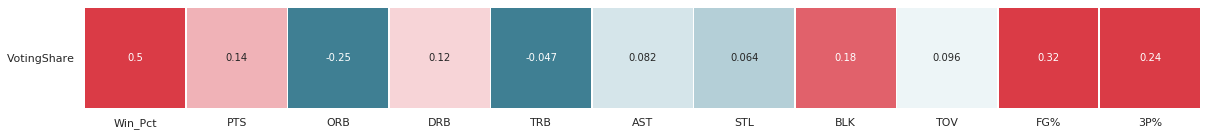

In [13]:
temp = tm.drop(columns=['Season', 'Tm', 'Candidate'])
corr = temp.corr()[['Win_Pct','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%']]
corr = corr.take([len(temp.corr().columns)-2])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
plt.yticks(rotation=0)
plt.show()

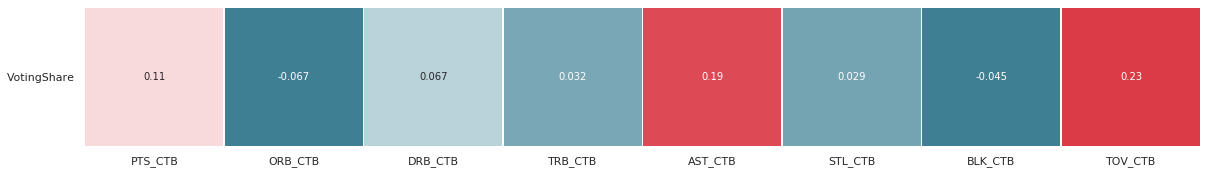

In [14]:
temp = ctb.drop(columns=['Season', 'Tm', 'Candidate'])
corr = temp.corr()[['PTS_CTB','ORB_CTB','DRB_CTB','TRB_CTB','AST_CTB','STL_CTB','BLK_CTB','TOV_CTB']]
corr = corr.take([1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
plt.yticks(rotation=0)
plt.show()

In [15]:
def select(pg, adv, tm, ctb, lists):
    pg_select = pg.copy(deep=True)[lists[0]]
    adv_select = adv.copy(deep=True)[lists[1]]
    tm_select = tm.copy(deep=True)[lists[2]]
    ctb_select = ctb.copy(deep=True)[lists[3]]
    return pd.concat([pg_select, adv_select, tm_select, ctb_select], axis=1)

In [16]:
def predict(name, season, reg, lists):
    link = str.lower(name.split()[1])[:1] + '/' + \
                        uni.unidecode(str.lower(name.split()[1]).replace("'", "").replace('-',''))[:5] + \
                            str.lower(name.split()[0]).replace("'", "")[:2] + '01'
    i = 2
    while season not in \
            list(pd.read_html('https://www.basketball-reference.com/players/' + link + '.html')[0]['Season']):
        link = str.lower(name.split()[1])[:1] + '/' + \
                        uni.unidecode(str.lower(name.split()[1]).replace("'", "").replace('-',''))[:5] + \
                            str.lower(name.split()[0]).replace("'", "")[:2] + '0' + str(i)
        i += 1
    
    data = browse(link)
    
    pergame = data[0]
    pergame.dropna(inplace=True)
    pergame = pergame[pergame['Season'] == season]
    pergame.reset_index(inplace=True,drop=True)
    pergame = pergame.reindex(columns=['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST',
                                       'STL', 'BLK', 'TOV', 'FG%', '3P%', 'eFG%', 'FT%'])

    advanced = data[1]
    if 'Unnamed: 19' in advanced.columns:
        advanced.drop(columns=['Unnamed: 19', 'Unnamed: 24'],inplace=True)
    advanced = advanced[advanced['Season'] == season]
    advanced.reset_index(inplace=True,drop=True)
    advanced = advanced.reindex(columns=['Season', 'Tm', 'Pos', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 
                                         'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 
                                         'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'])

    tm = pergame['Tm'][0]
    if tm == 'NOP': 
        tm = 'NOH'
    elif tm == 'BRK': 
        tm = 'NJN'
    elif tm == 'CHO':
        tm = 'CHA'
    team = pd.read_html('https://www.basketball-reference.com/teams/' + tm + '/stats_per_game_totals.html')[0]
    team = team[team['Season'] == season]
    team['Win_Pct'] = team['W'].astype(int)/team['G'].astype(int)
    team.reset_index(inplace=True,drop=True)
    team = team.reindex(columns=['Season', 'Tm', 'W', 'L', 'Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 
                                   'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%'])

    ctb = pergame.copy(deep=True)[['Season', 'Tm', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 
                                    '3P%', 'FT%']]
    ctb['PTS_CTB'] = float(ctb['PTS'])/float(team['PTS'])
    ctb['ORB_CTB'] = float(ctb['ORB'])/float(team['ORB'])
    ctb['DRB_CTB'] = float(ctb['DRB'])/float(team['DRB'])
    ctb['TRB_CTB'] = float(ctb['TRB'])/float(team['TRB'])
    ctb['AST_CTB'] = float(ctb['AST'])/float(team['AST'])
    ctb['STL_CTB'] = float(ctb['STL'])/float(team['STL'])
    ctb['BLK_CTB'] = float(ctb['BLK'])/float(team['BLK'])
    ctb['TOV_CTB'] = float(ctb['TOV'])/float(team['TOV'])
    ctb.drop(columns=['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%'], inplace=True)
    select_test = select(pergame, advanced, team, ctb, lists)
    return reg.predict(select_test)[0]

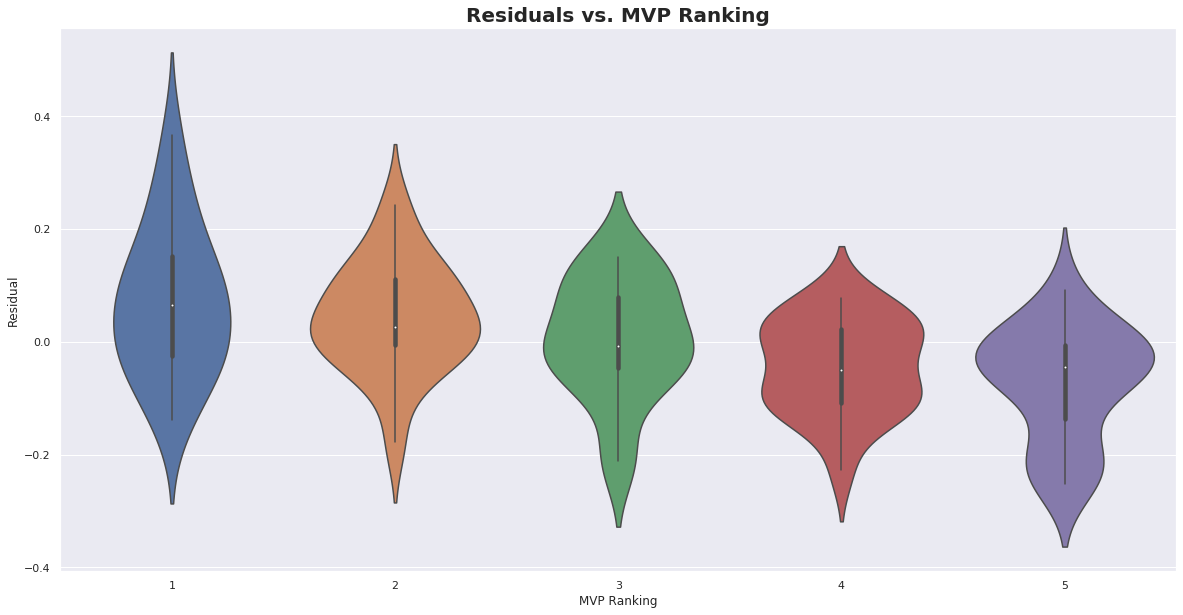

In [17]:
pg_list = ['Ranking', 'G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'eFG%', 
           'FT%']
adv_list = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
            'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
tm_list = ['W', 'L', 'Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%']
ctb_list = ['PTS_CTB', 'ORB_CTB', 'DRB_CTB', 'TRB_CTB', 'AST_CTB', 'STL_CTB', 'BLK_CTB', 'TOV_CTB']
X = select(pg, adv, tm, ctb, [pg_list, adv_list, tm_list, ctb_list])
y = pg['VotingShare']
reg1 = linear_model.LinearRegression()
reg1.fit(X.drop(columns=['Ranking']), y)
rsd = y - reg1.predict(X.drop(columns=['Ranking']))
rsd
plt.figure(figsize=(20,10))
sns.violinplot(x=X['Ranking'],y=rsd)
plt.title('Residuals vs. MVP Ranking', fontweight="bold", fontsize=20)
plt.xlabel('MVP Ranking')
plt.ylabel('Residual')
# plt.xticks(rotation=90)
plt.show()

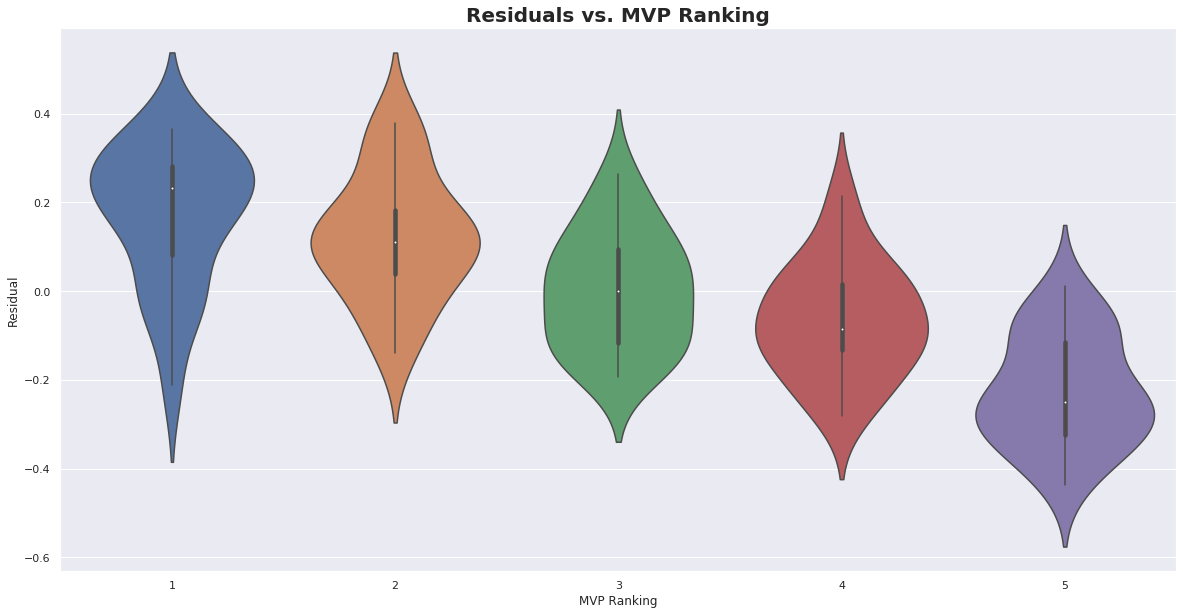

In [19]:
pg_list = ['Ranking', 'G', 'PTS', 'AST', 'eFG%']
adv_list = ['PER', 'WS', 'VORP']
tm_list = ['Win_Pct']
ctb_list = ['PTS_CTB', 'AST_CTB']
X = select(pg, adv, tm, ctb, [pg_list, adv_list, tm_list, ctb_list])
y = pg['VotingShare']
reg2 = linear_model.LinearRegression()
reg2.fit(X.drop(columns=['Ranking']), y)
rsd = y - reg2.predict(X.drop(columns=['Ranking']))
plt.figure(figsize=(20,10))
sns.violinplot(x=X['Ranking'],y=rsd)
plt.title('Residuals vs. MVP Ranking', fontweight="bold", fontsize=20)
plt.xlabel('MVP Ranking')
plt.ylabel('Residual')
plt.show()

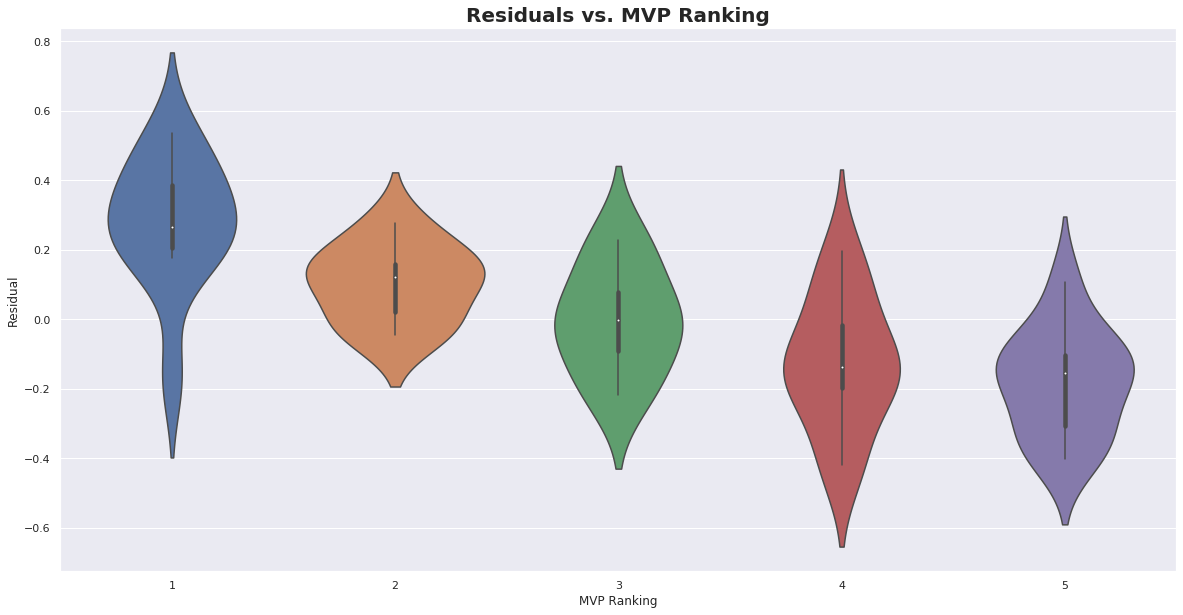

In [21]:
pg_list = ['Ranking', 'G', 'PTS', 'AST', 'eFG%']
adv_list = ['PER', 'WS', 'VORP']
tm_list = ['Win_Pct']
ctb_list = ['PTS_CTB', 'AST_CTB']
X = select(pg, adv, tm, ctb, [pg_list, adv_list, tm_list, ctb_list])
y = pg['VotingShare']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train = X_train.drop(columns=['Ranking'])
reg3 = linear_model.LinearRegression()
reg3.fit(X_train, y_train)
rsd = y_test - reg3.predict(X_test.drop(columns=['Ranking']))
plt.figure(figsize=(20,10))
sns.violinplot(x=X_test['Ranking'],y=rsd)
plt.title('Residuals vs. MVP Ranking', fontweight="bold", fontsize=20)
plt.xlabel('MVP Ranking')
plt.ylabel('Residual')
plt.show()

In [23]:
tables = pd.read_html('https://basketball.realgm.com/nba/players/2019')
table = tables[12].copy(deep=True)[tables[12]['GP'] >= 41]
j = 0
for i, x in table.iterrows():
    if len(x['Teams']) > 3:
        table.drop(table.index[j], inplace=True)
        j -= 1
    j += 1
players = table['Player'].sample(n=5)
pg_list = ['G', 'PTS', 'AST', 'eFG%']
adv_list = ['PER', 'WS', 'VORP']
tm_list = ['Win_Pct']
ctb_list = ['PTS_CTB', 'AST_CTB']
lists = [pg_list, adv_list, tm_list, ctb_list]
predictions = pd.DataFrame()
for name in players:
    print(name)
    prediction = predict(name, '2018-19', reg3, lists)
    predictions = predictions.append(pd.DataFrame([[name, prediction]], columns=['Player', 
                        'Predicted VotingShare']), sort=False).reset_index()[['Player', 'Predicted VotingShare']]
predictions

Elfrid Payton
Marcus Smart
D'Angelo Russell
Deandre Ayton
Furkan Korkmaz


,Player,Predicted VotingShare
0,Elfrid Payton,-0.950470
1,Marcus Smart,-0.104546
2,D'Angelo Russell,0.138895
3,Deandre Ayton,-0.570357
4,Furkan Korkmaz,-0.675899
